In [7]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
import pandas as pd

df = pd.read_csv('HateSpeechDataset.csv')
df = df.drop(columns=['Content_int'], errors='ignore')
df = df[df['Label'] != 'Label']

In [13]:
import re
import numpy as np
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 假设你的DataFrame是 df，包含Content和Label两列
# 预处理文本
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # 去除标点符号
    text = text.lower()  # 转小写
    return word_tokenize(text)  # 分词

In [14]:
df['Content'] = df['Content'].apply(preprocess_text)

In [16]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Add
from tensorflow.keras.models import Model

# 定义ResNet残差块
def resnet_block(x, filters, kernel_size):
    residual = Conv1D(filters, kernel_size, padding="same")(x)
    residual = GlobalMaxPooling1D()(residual)
    
    # 第二层卷积
    x = Conv1D(filters, kernel_size, padding="same")(x)
    x = Conv1D(filters, kernel_size, padding="same")(x)
    
    # 残差连接
    x = Add()([x, residual])
    return x

# 输入层
input_text = Input(shape=(100,))
embedding_layer = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_text)

# ResNet残差块
x = resnet_block(embedding_layer, filters=64, kernel_size=3)

# 输出层
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # 假设是二分类任务

# 构建模型
model = Model(inputs=input_text, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 打印模型摘要
model.summary()


/root/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
W0000 00:00:1734595592.386620    3043 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │     24,640 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │     24,640 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 64)   │     12,352 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ add[0][0]         │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 705,857 (2.69 MB)

 Trainable params: 705,857 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import numpy as np
# 创建Tokenizer并将文本转为数字序列
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Content'])
X = tokenizer.texts_to_sequences(df['Content'])

# 填充序列以使其长度一致
X = pad_sequences(X, maxlen=100)

# 标签处理（假设是二分类问题）
y = df['Label'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# 训练模型
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
11023/11023 ━━━━━━━━━━━━━━━━━━━━ 509s 46ms/step - accuracy: 0.8569 - loss: 0.3227 - val_accuracy: 0.8747 - val_loss: 0.2800
Epoch 2/5
11023/11023 ━━━━━━━━━━━━━━━━━━━━ 504s 46ms/step - accuracy: 0.8838 - loss: 0.2603 - val_accuracy: 0.8806 - val_loss: 0.2718
Epoch 3/5
11023/11023 ━━━━━━━━━━━━━━━━━━━━ 425s 39ms/step - accuracy: 0.8961 - loss: 0.2376 - val_accuracy: 0.8820 - val_loss: 0.2683
Epoch 4/5
11023/11023 ━━━━━━━━━━━━━━━━━━━━ 499s 45ms/step - accuracy: 0.9058 - loss: 0.2154 - val_accuracy: 0.8811 - val_loss: 0.2765
Epoch 5/5
11023/11023 ━━━━━━━━━━━━━━━━━━━━ 516s 47ms/step - accuracy: 0.9163 - loss: 0.1935 - val_accuracy: 0.8760 - val_loss: 0.2853


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 预测标签
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 计算评估指标
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 输出结果
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step
Accuracy: 0.8760
Precision: 0.6692
Recall: 0.6125
F1-score: 0.6396


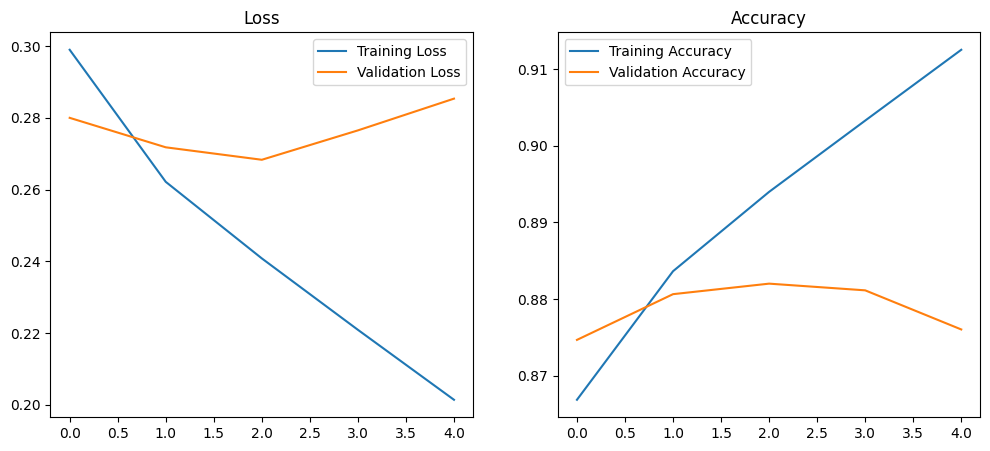

In [19]:
import matplotlib.pyplot as plt

# 绘制训练过程
plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [ ]:
print(X_train.dtype, X_test.dtype)
print(y_train.dtype, y_test.dtype)